# Experiment 1: K-Means on Original Data
This notebook replicates `Exp1.py`: run K-Means on the breast cancer dataset, compare kmeans++ vs random init, pick k via elbow, silhouette, and gap statistic, and report internal/external metrics plus confusion matrices.

In [ ]:
# Setup and Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
import part3

# Plot style
sns.set(style="whitegrid")

In [ ]:
# Load and Standardize Dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [ ]:
# Helper: Within-Cluster Sum of Squares

def _within_cluster_ss(X, labels, centroids):
    ss = 0.0
    for i in range(centroids.shape[0]):
        pts = X[labels == i]
        if pts.size == 0:
            continue
        diff = pts - centroids[i]
        ss += np.sum(diff * diff)
    return ss

In [ ]:
# Helper: Gap Statistic and Optimal k Selection

def gap_statistic(X, k_max=10, B=10, init="kmeans++", max_iter=300, tol=1e-4, random_state=42):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    mins = X.min(axis=0)
    maxs = X.max(axis=0)

    Wks = np.zeros(k_max)
    Wkbs = np.zeros((k_max, B))

    for k in range(1, k_max + 1):
        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km.fit(X)
        Wks[k - 1] = _within_cluster_ss(X, km.labels_, km.centroids_)

        for b in range(B):
            Xb = rng.uniform(mins, maxs, size=(n_samples, n_features))
            km_b = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
            np.random.seed(int(rng.integers(0, 2**32 - 1)))
            km_b.fit(Xb)
            Wkbs[k - 1, b] = _within_cluster_ss(Xb, km_b.labels_, km_b.centroids_)

    logWks = np.log(Wks)
    logWkbs = np.log(Wkbs)
    gaps = np.mean(logWkbs, axis=1) - logWks
    sk = np.sqrt(1 + 1.0 / B) * np.std(logWkbs, axis=1)
    return gaps, sk


def select_gap_k(gaps, sk):
    k_vals = np.arange(1, len(gaps) + 1)
    for i in range(len(gaps) - 1):
        if gaps[i] >= gaps[i + 1] - sk[i + 1]:
            return k_vals[i]
    return k_vals[-1]

In [ ]:
# Run KMeans Across k Values

def run_kmeans_series(X, y_true, k_values, init_method, tol=1e-4, max_iter=300, random_state=42):
    rng = np.random.default_rng(random_state)
    records = {
        "inertia": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "time": [],
        "iterations": [],
        "labels": []
    }

    for k in k_values:
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        km = KMeans(k=k, init=init_method, max_iter=max_iter, tol=tol)
        start = time.time()
        km.fit(X)
        elapsed = time.time() - start
        labels = km.labels_

        records["inertia"].append(km.inertia_)
        records["time"].append(elapsed)
        records["iterations"].append(km.iterations_)

        if k > 1:
            sil, _ = part3.silhouette_score(X, labels)
            dbi = part3.davies_bouldin_index(X, labels)
            chi = part3.calinski_harabasz_index(X, labels)
        else:
            sil, dbi, chi = np.nan, np.nan, np.nan

        records["silhouette"].append(sil)
        records["davies_bouldin"].append(dbi)
        records["calinski_harabasz"].append(chi)
        records["wcss"].append(part3.within_cluster_sum_of_squares(X, labels))
        records["labels"].append(labels)

        records["ari"].append(part3.adjusted_rand_index(y_true, labels))
        records["nmi"].append(part3.normalized_mutual_information(y_true, labels))
        records["purity"].append(part3.purity_score(y_true, labels))

    return records

In [ ]:
# Elbow and Silhouette Heuristics

def pick_elbow_k(k_values, inertia_values):
    inertia_arr = np.array(inertia_values)
    if len(inertia_arr) < 3:
        return k_values[len(k_values) // 2]
    second = np.diff(inertia_arr, n=2)
    idx = np.argmax(second) + 1
    return k_values[idx]


def best_silhouette_k(k_values, silhouette_values):
    return k_values[int(np.nanargmax(silhouette_values))]

In [ ]:
# Plot Internal Metrics and Convergence

def plot_metric_curves(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["inertia"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow (Inertia)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["silhouette"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Silhouette")
    plt.title("Silhouette Analysis")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_internal_metrics(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["davies_bouldin"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["calinski_harabasz"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs k")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_convergence(k_values, results_by_init):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["iterations"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Iterations")
    plt.title("Convergence speed (iterations)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    for init_method, res in results_by_init.items():
        plt.plot(k_values, res["time"], marker="o", label=init_method)
    plt.xlabel("k")
    plt.ylabel("Time (s)")
    plt.title("Convergence speed (time)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Compute and Plot Gap Statistic

def plot_gap(k_values, gaps, sk, optimal_k):
    plt.figure(figsize=(8, 5))
    plt.errorbar(k_values, gaps, yerr=sk, fmt="o-", capsize=5, label="Gap")
    plt.axvline(optimal_k, color="r", linestyle="--", label=f"Optimal k={optimal_k}")
    plt.xlabel("k")
    plt.ylabel("Gap statistic")
    plt.title("Gap Statistic")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_gap_and_plot(X, max_k, init="kmeans++", B=10):
    gaps, sk = gap_statistic(X, k_max=max_k, init=init, B=B, random_state=42)
    gap_k = select_gap_k(gaps, sk)
    plot_gap(np.arange(1, len(gaps) + 1), gaps, sk, gap_k)
    print(f"Gap statistic optimal k={gap_k}")
    return gaps, sk, gap_k

In [ ]:
# External Metrics at k=2 with Confusion Matrix

def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def report_k2_confusion(results, k_values, y_true):
    k_report = 2
    if k_report not in k_values:
        print("k=2 not in k_values; skipping confusion matrices.")
        return
    idx = k_values.index(k_report)
    for init_method, res in results.items():
        print(
            f"Init={init_method}, k={k_report}: "
            f"ARI={res['ari'][idx]:.3f}, NMI={res['nmi'][idx]:.3f}, Purity={res['purity'][idx]:.3f}, "
            f"WCSS={res['wcss'][idx]:.1f}, Silhouette={res['silhouette'][idx]:.3f}"
        )
        cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, res["labels"][idx])
        title = f"Confusion Matrix (init={init_method}, k={k_report})"
        plot_confusion(cm, true_classes, pred_clusters, title)

Init=kmeans++: elbow k=3, silhouette-opt k=2
Init=random: elbow k=3, silhouette-opt k=2


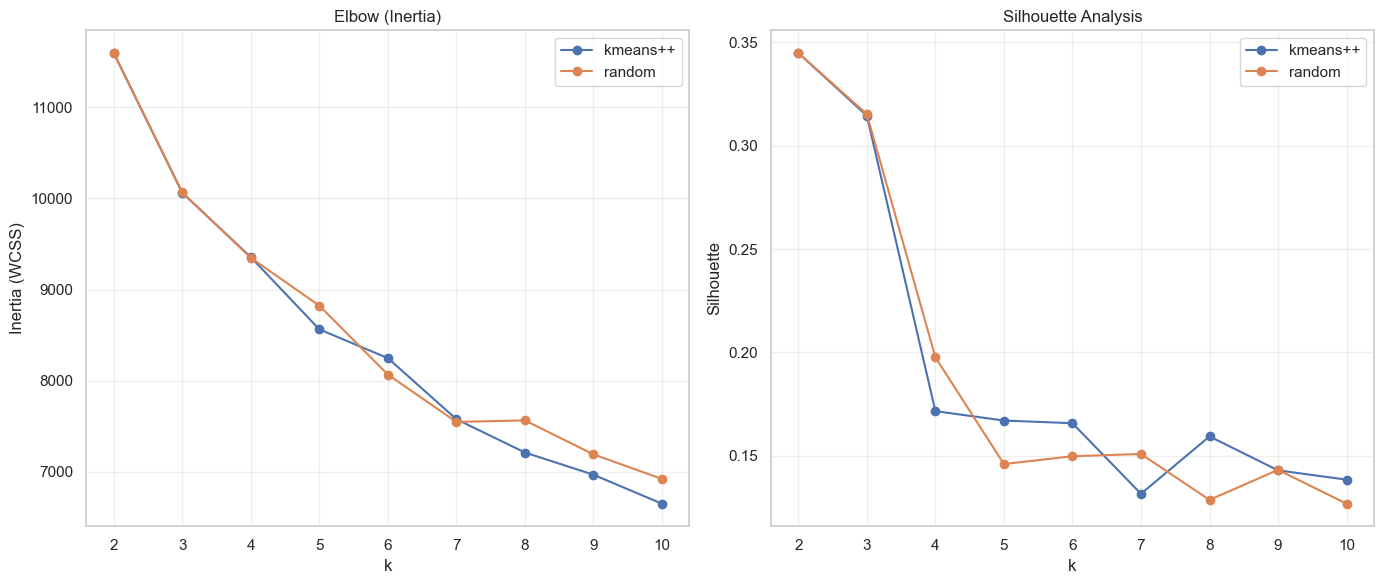

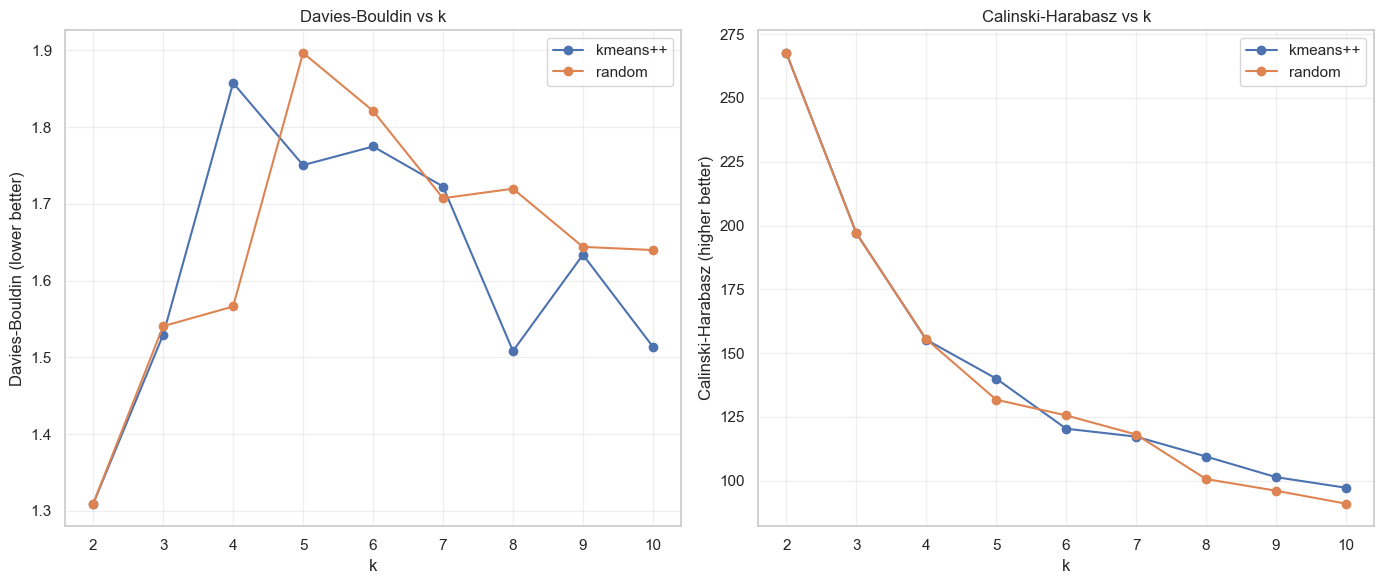

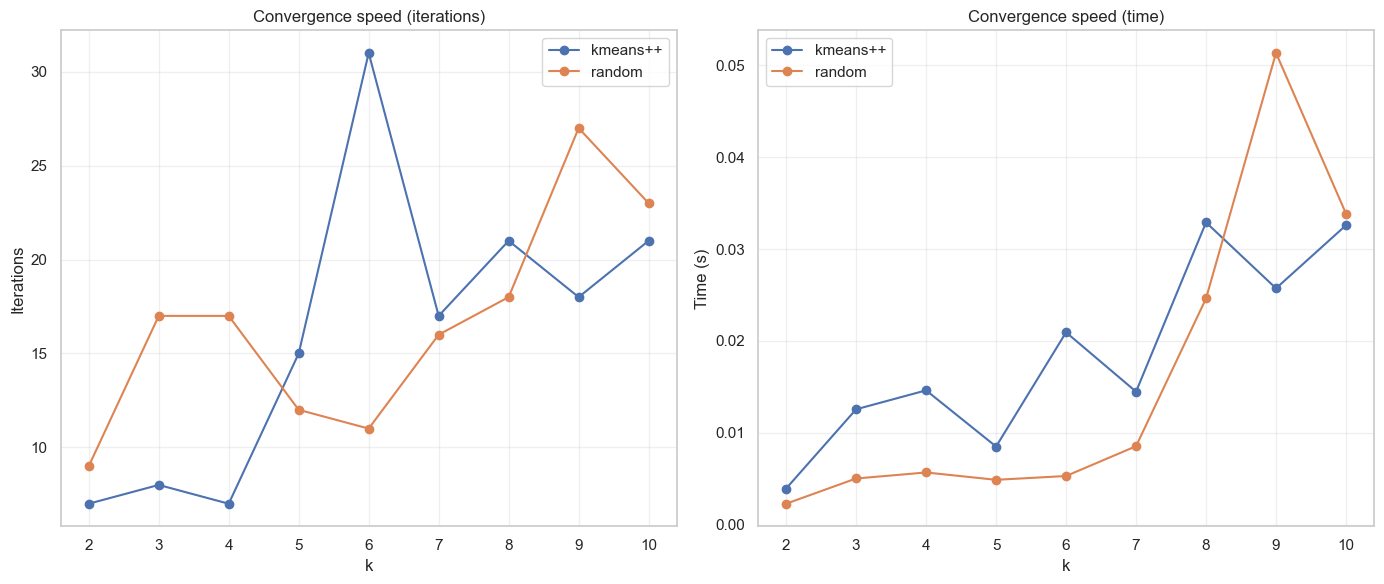

Computing gap statistic (kmeans++ init)...


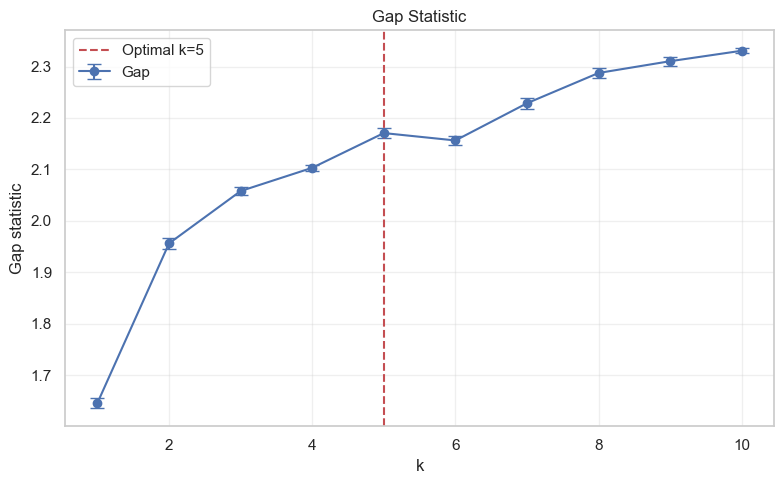

Gap statistic optimal k=5
Init=kmeans++, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


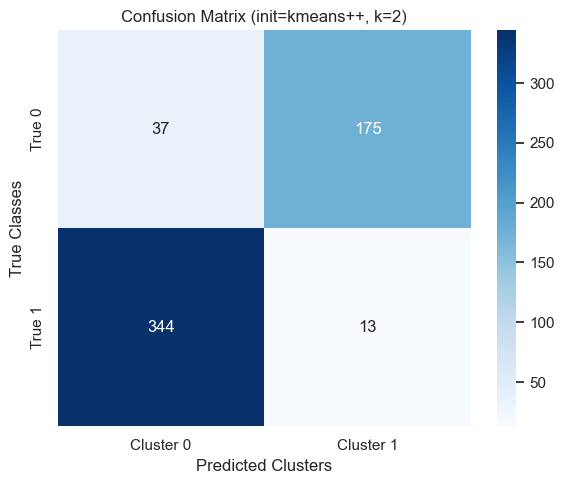

Init=random, k=2: ARI=0.677, NMI=0.562, Purity=0.912, WCSS=11595.7, Silhouette=0.345


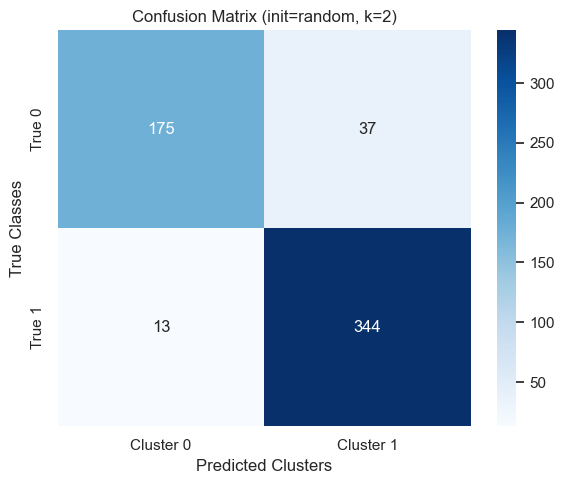

In [ ]:
# Run the experiment end-to-end
k_values = list(range(2, 11))

results = {}
for init_method in ["kmeans++", "random"]:
    res = run_kmeans_series(X, y_true, k_values, init_method)
    results[init_method] = res
    elbow_k = pick_elbow_k(k_values, res["inertia"])
    best_sil_k = best_silhouette_k(k_values, res["silhouette"])
    print(f"Init={init_method}: elbow k={elbow_k}, silhouette-opt k={best_sil_k}")

plot_metric_curves(k_values, results)
plot_internal_metrics(k_values, results)
plot_convergence(k_values, results)

print("Computing gap statistic (kmeans++ init)...")
gaps, sk, gap_k = compute_gap_and_plot(X, max_k=max(k_values), init="kmeans++", B=10)

report_k2_confusion(results, k_values, y_true)

# **Experiment 2** =GMM on Original Data

## Load csv file

In [ ]:
import pandas as pd
import numpy as np

def load_data(file_path, random_state=None):
    data = pd.read_csv(file_path)
    y = data['diagnosis'].values
    # Convert to numeric if string labels (e.g., 'M', 'B' -> 0, 1)
    if y.dtype == 'object':
        unique_labels = np.unique(y)
        label_map = {label: i for i, label in enumerate(unique_labels)}
        y = np.array([label_map[label] for label in y])
    
    # Remove non-feature columns
    columns_to_drop = []
    if 'id' in data.columns:
        columns_to_drop.append('id')
    if 'diagnosis' in data.columns:
        columns_to_drop.append('diagnosis')
    
    if columns_to_drop:
        data = data.drop(columns=columns_to_drop)
    
    # Store feature names
    feature_names = list(data.columns)
    
    # Fill missing values with column-wise mean
    data = data.fillna(data.mean())
    
    # Convert to NumPy arrays
    X = data.values.astype(float)
    
    # Compute mean and std
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1.0  # prevent division by zero
    
    # Standardize
    X = (X - mean) / std
    
    # Store preprocessing parameters
    preprocessing_params = {
        'mean': mean,
        'std': std,
        'feature_names': feature_names
    }
    
    print(f"Loaded data: {X.shape[0]} samples, {X.shape[1]} features")
    if y is not None:
        print(f"Target classes: {np.unique(y)} (counts: {np.bincount(y)})")
    
    return X, y, feature_names, preprocessing_params

In [ ]:
def initialize_parameters(X, n_components, covariance_type='full', random_state=None):
    """
    Initialize GMM parameters using k-means++ style initialization.
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        Training data
    n_components : int
        Number of Gaussian components
    covariance_type : str
        Type of covariance: 'full', 'tied', 'diagonal', 'spherical'
    random_state : int or None
        Random seed for reproducibility
        
    Returns:
    --------
    means : array, shape (n_components, n_features)
    covariances : array or float
        Shape depends on covariance_type
    weights : array, shape (n_components,)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples, n_features = X.shape
    
    # Initialize means using k-means++ style
    means = np.zeros((n_components, n_features))
    
    # First center: random sample
    means[0] = X[np.random.randint(n_samples)]
    
    for k in range(1, n_components):
        # Compute distances to nearest center
        distances = np.min([np.sum((X - means[j])**2, axis=1) 
                           for j in range(k)], axis=0)
        
        # Add small epsilon to avoid numerical issues
        distances = np.maximum(distances, 1e-10)
        
        # Compute probabilities
        distance_sum = distances.sum()
        
        # Check for edge cases
        if distance_sum < 1e-10:
            # All points are very close to existing centers
            # Choose a random point
            means[k] = X[np.random.randint(n_samples)]
        else:
            probs = distances / distance_sum
            
            # Additional safety check: ensure probs sum to 1 and contain no NaN
            if np.any(np.isnan(probs)) or np.abs(probs.sum() - 1.0) > 1e-6:
                # Fallback to uniform random selection
                means[k] = X[np.random.randint(n_samples)]
            else:
                # Normalize to ensure exact sum to 1
                probs = probs / probs.sum()
                means[k] = X[np.random.choice(n_samples, p=probs)]
    
    # Initialize covariances
    covariances = initialize_covariances(X, n_components, covariance_type)
    
    # Initialize weights uniformly
    weights = np.ones(n_components) / n_components
    
    return means, covariances, weights

def initialize_covariances(X, n_components, covariance_type):
    """
    Initialize covariance matrices based on type.
    """
    n_features = X.shape[1]
    
    # Compute overall covariance of data
    data_cov = np.cov(X.T) + 1e-6 * np.eye(n_features)
    
    if covariance_type == 'full':
        # Each component has its own full covariance matrix
        covariances = np.array([data_cov for _ in range(n_components)])
        
    elif covariance_type == 'tied':
        # All components share the same covariance matrix
        covariances = data_cov
        
    elif covariance_type == 'diagonal':
        # Each component has diagonal covariance
        diag_cov = np.diag(np.diag(data_cov))
        covariances = np.array([diag_cov for _ in range(n_components)])
        
    elif covariance_type == 'spherical':
        # Each component has spherical covariance (scalar * I)
        variance = np.mean(np.diag(data_cov))
        covariances = np.array([variance for _ in range(n_components)])
    
    return covariances

In [ ]:
# GAUSSIAN PROBABILITY DENSITY FUNCTION
def compute_gaussian_pdf(X, mean, covariance, covariance_type):
    """
    Compute Gaussian probability density function.
    """
    n_samples, n_features = X.shape
    diff = X - mean
    
    if covariance_type == 'full' or covariance_type == 'tied':
        # Full or tied covariance matrix
        cov_inv = np.linalg.inv(covariance)
        det = np.linalg.det(covariance)
        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det)
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        return norm_const * np.exp(exponent)
            
    elif covariance_type == 'diagonal':
        # Diagonal covariance
        cov_diag = np.diag(covariance)
        det = np.prod(cov_diag)
        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det)
        exponent = -0.5 * np.sum((diff**2) / cov_diag, axis=1)
        return norm_const * np.exp(exponent)
        
    elif covariance_type == 'spherical':
        # Spherical covariance (scalar variance)
        variance = covariance
        det = variance**n_features
        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det)
        exponent = -0.5 * np.sum(diff**2, axis=1) / variance
        return norm_const * np.exp(exponent)

In [ ]:
# E-STEP: EXPECTATION
def e_step(X, means, covariances, weights, covariance_type):
    """
    E-step: Compute responsibilities (posterior probabilities).
    """
    n_samples = X.shape[0]
    n_components = len(means)
    
    # Compute weighted probabilities for each component
    weighted_prob = np.zeros((n_samples, n_components))
    
    for k in range(n_components):
        if covariance_type == 'tied':
            cov = covariances
        elif covariance_type in ['full', 'diagonal', 'spherical']:
            cov = covariances[k]
        # Compute probability density
        prob = compute_gaussian_pdf(X, means[k], cov, covariance_type)
        weighted_prob[:, k] = weights[k] * prob
    
    # Compute total probability (sum over components)
    total_prob = np.sum(weighted_prob, axis=1, keepdims=True)
    
    # Add small constant for numerical stability
    total_prob = np.maximum(total_prob, 1e-300)
    
    # Compute responsibilities (normalize)
    responsibilities = weighted_prob / total_prob
    
    # Compute log-likelihood
    log_likelihood = np.sum(np.log(total_prob.flatten()))
    
    return responsibilities, log_likelihood

In [ ]:
# M-STEP: MAXIMIZATION
def m_step(X, responsibilities, covariance_type, reg_covar=1e-6):
    """
    M-step: Update parameters to maximize expected log-likelihood.
    reg_covar : float
        Regularization added to diagonal for numerical stability
    """
    n_samples, n_features = X.shape
    n_components = responsibilities.shape[1]
    
    # Compute effective number of samples per component
    Nk = np.sum(responsibilities, axis=0)
    
    # Update weights
    weights = Nk / n_samples
    
    # Update means
    means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
    
    # Update covariances based on type
    covariances = update_covariances(X, responsibilities, means, Nk, 
                                    covariance_type, reg_covar)
    
    return means, covariances, weights


def update_covariances(X, responsibilities, means, Nk, covariance_type, reg_covar):
    """
    Update covariance matrices based on type.
    Nk : array, shape (n_components,)
        Effective number of samples per component
    """
    n_samples, n_features = X.shape
    n_components = len(means)
    
    if covariance_type == 'full':
        # Full covariance for each component
        covariances = np.zeros((n_components, n_features, n_features))
        for k in range(n_components):
            diff = X - means[k]
            weighted_diff = responsibilities[:, k:k+1] * diff
            covariances[k] = np.dot(weighted_diff.T, diff) / Nk[k]
            # Add regularization for numerical stability
            covariances[k] += reg_covar * np.eye(n_features)
            
    elif covariance_type == 'tied':
        # Single shared covariance matrix
        covariances = np.zeros((n_features, n_features))
        for k in range(n_components):
            diff = X - means[k]
            weighted_diff = responsibilities[:, k:k+1] * diff
            covariances += np.dot(weighted_diff.T, diff)
        covariances /= n_samples
        covariances += reg_covar * np.eye(n_features)
        
    elif covariance_type == 'diagonal':
        # Diagonal covariance for each component
        covariances = np.zeros((n_components, n_features, n_features))
        for k in range(n_components):
            diff = X - means[k]
            weighted_sq_diff = responsibilities[:, k:k+1] * (diff**2)
            variance = np.sum(weighted_sq_diff, axis=0) / Nk[k]
            covariances[k] = np.diag(variance + reg_covar)
            
    elif covariance_type == 'spherical':
        # Spherical covariance for each component (scalar variance)
        covariances = np.zeros(n_components)
        for k in range(n_components):
            diff = X - means[k]
            weighted_sq_diff = responsibilities[:, k:k+1] * (diff**2)
            covariances[k] = np.sum(weighted_sq_diff) / (Nk[k] * n_features)
            covariances[k] += reg_covar
    
    return covariances

In [ ]:
# CONVERGENCE MONITORING
def check_convergence(log_likelihood_history, tol=1e-3, n_iter=10):
    """
    Check if EM algorithm has converged.
    """
    if len(log_likelihood_history) < n_iter:
        return False
    
    # Check relative change in log-likelihood
    current_ll = log_likelihood_history[-1]
    previous_ll = log_likelihood_history[-2]
    
    # Avoid division by zero
    if abs(previous_ll) < 1e-10:
        change = abs(current_ll - previous_ll)
    else:
        change = abs((current_ll - previous_ll) / previous_ll)
    
    return change < tol

In [ ]:
# MAIN EM ALGORITHM
def fit_gmm(X, n_components, covariance_type='full', max_iter=100, 
            tol=1e-3, reg_covar=1e-6, random_state=None, verbose=False):
    # Initialize parameters
    means, covariances, weights = initialize_parameters(
        X, n_components, covariance_type, random_state
    )
    
    log_likelihood_history = []
    
    for iteration in range(max_iter):
        # E-step: Compute responsibilities
        responsibilities, log_likelihood = e_step(
            X, means, covariances, weights, covariance_type
        )
        
        log_likelihood_history.append(log_likelihood)
        
        if verbose:
            print(f"Iteration {iteration + 1}: Log-likelihood = {log_likelihood:.4f}")
        
        # Check convergence
        if iteration > 0 and check_convergence(log_likelihood_history, tol):
            if verbose:
                print(f"Converged at iteration {iteration + 1}")
            converged = True
            break
        
        # M-step: Update parameters
        means, covariances, weights = m_step(
            X, responsibilities, covariance_type, reg_covar
        )
        
        converged = False
    
    return {
        'means': means,
        'covariances': covariances,
        'weights': weights,
        'log_likelihood': log_likelihood_history[-1],
        'log_likelihood_history': log_likelihood_history,
        'converged': converged,
        'n_iter': len(log_likelihood_history)
    }

In [ ]:
def predict_proba(X, means, covariances, weights, covariance_type):
    responsibilities, _ = e_step(X, means, covariances, weights, covariance_type)
    return responsibilities


def predict(X, means, covariances, weights, covariance_type):
    probabilities = predict_proba(X, means, covariances, weights, covariance_type)
    return np.argmax(probabilities, axis=1)

## Find optimal components using BIC and AIC

In [ ]:

def compute_bic_aic(X, n_components, log_likelihood, covariance_type):
    """
    Compute BIC and AIC for GMM.
    
    BIC = -2 * log(L) + k * log(n)
    AIC = -2 * log(L) + 2k
    
    where:
    - log(L) = log-likelihood
    - k = number of parameters
    - n = number of samples
    
    Lower BIC/AIC indicates better model.
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
    n_components : int
    log_likelihood : float
    covariance_type : str
    
    Returns:
    --------
    bic : float
    aic : float
    """
    n_samples, n_features = X.shape
    
    # Count parameters based on covariance type
    # Means: K * d
    # Weights: K - 1 (sum to 1)
    n_params = n_components * n_features + (n_components - 1)
    
    # Covariances:
    if covariance_type == 'full':
        # K * d * (d + 1) / 2
        n_params += n_components * n_features * (n_features + 1) // 2
    elif covariance_type == 'tied':
        # d * (d + 1) / 2
        n_params += n_features * (n_features + 1) // 2
    elif covariance_type == 'diagonal':
        # K * d
        n_params += n_components * n_features
    elif covariance_type == 'spherical':
        # K
        n_params += n_components
    
    bic = -2 * log_likelihood + n_params * np.log(n_samples)
    aic = -2 * log_likelihood + 2 * n_params
    
    return bic, aic


In [ ]:
from matplotlib import pyplot as plt
def plot_bic_aic_curves(k_values, bic_scores, aic_scores, save_path=None):
    """
    Plot BIC and AIC curves for GMM.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, bic_scores, 'bo-', label='BIC', linewidth=2, markersize=8)
    plt.plot(k_values, aic_scores, 'rs-', label='AIC', linewidth=2, markersize=8)
    
    optimal_k_bic = k_values[np.argmin(bic_scores)]
    optimal_k_aic = k_values[np.argmin(aic_scores)]
    
    plt.axvline(x=optimal_k_bic, color='b', linestyle='--', alpha=0.5)
    plt.axvline(x=optimal_k_aic, color='r', linestyle='--', alpha=0.5)
    
    plt.xlabel('Number of Components (k)', fontsize=12)
    plt.ylabel('Information Criterion', fontsize=12)
    plt.title('GMM Model Selection - BIC & AIC', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

In [ ]:
def confusion_matrix(true_labels, pred_labels):
    true_unique = np.unique(true_labels)
    pred_unique = np.unique(pred_labels)
    
    cm = np.zeros((len(true_unique), len(pred_unique)), dtype=int)
    
    for i, t in enumerate(true_unique):
        for j, p in enumerate(pred_unique):
            cm[i, j] = np.sum((true_labels == t) & (pred_labels == p))
    
    return cm, true_unique, pred_unique

def cluster_composition(true_labels, cluster_labels):
    clusters = np.unique(cluster_labels)
    classes = np.unique(true_labels)
    
    composition = {}
    
    for cluster in clusters:
        indices = np.where(cluster_labels == cluster)[0]
        class_counts = {cls: np.sum(true_labels[indices] == cls) for cls in classes}
        composition[cluster] = class_counts
        
    return composition

def unsupervised_confusion_matrix(true_labels, cluster_labels):
    clusters = np.unique(cluster_labels)
    classes = np.unique(true_labels)
    cm = np.zeros((len(classes), len(clusters)), dtype=int)
    
    for i, cls in enumerate(classes):
        for j, cluster in enumerate(clusters):
            cm[i, j] = np.sum((true_labels == cls) & (cluster_labels == cluster))
    
    return cm

In [ ]:

def plot_2d_projection(X_2d, labels, title='2D Projection', true_labels=None, 
                       centers=None, save_path=None):
    """
    Plot 2D projection of data with cluster assignments.
    
    Parameters:
    -----------
    X_2d : array, shape (n_samples, 2)
    labels : array, shape (n_samples,)
        Predicted cluster labels
    title : str
    true_labels : array or None
        True labels for comparison
    centers : array or None, shape (n_clusters, 2)
        Cluster centers
    save_path : str or None
    """
    fig, axes = plt.subplots(1, 2 if true_labels is not None else 1, 
                             figsize=(15 if true_labels is not None else 8, 6))
    
    if true_labels is None:
        axes = [axes]
    
    # Plot predicted labels
    scatter = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels, 
                             cmap='tab10', alpha=0.6, s=30)
    if centers is not None:
        axes[0].scatter(centers[:, 0], centers[:, 1], c='red', 
                       marker='X', s=200, edgecolors='black', linewidths=2,
                       label='Centers')
        axes[0].legend()
    
    axes[0].set_title(f'{title} - Predicted Clusters')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    plt.colorbar(scatter, ax=axes[0])
    
    # Plot true labels if available
    if true_labels is not None:
        scatter = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=true_labels,
                                 cmap='tab10', alpha=0.6, s=30)
        axes[1].set_title(f'{title} - True Labels')
        axes[1].set_xlabel('Component 1')
        axes[1].set_ylabel('Component 2')
        plt.colorbar(scatter, ax=axes[1])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()



Loaded data: 569 samples, 30 features
Target classes: [0 1] (counts: [357 212])


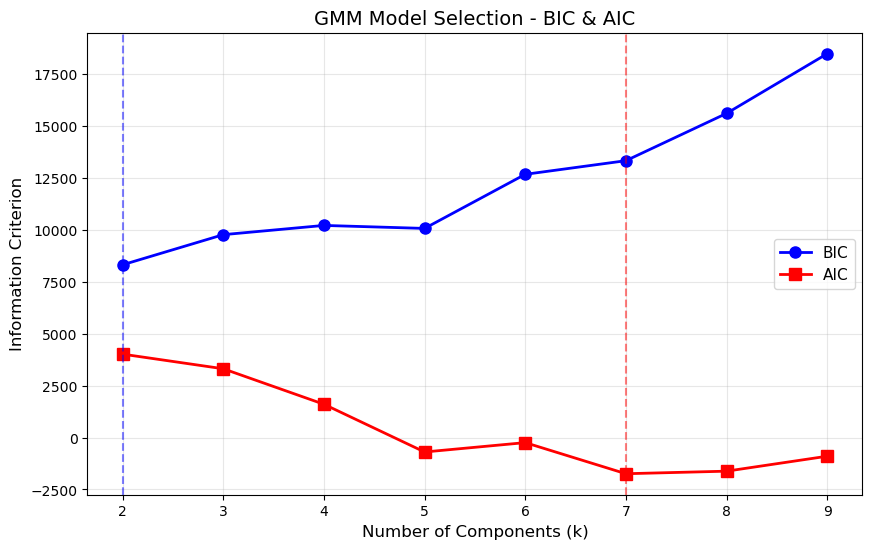

In [ ]:
X, y, _, _ = load_data('data.csv', random_state=42)
bic_scores_gmm, aic_scores_gmm = [], []
k_values_gmm = range(2, 10)
mapped_labels_arr_gmm = []
for k in k_values_gmm:
    model = fit_gmm(X, n_components=k, covariance_type='full', max_iter=100, 
            tol=1e-3, reg_covar=1e-6, random_state=42, verbose=False)
    bic, aic = compute_bic_aic(X, k, model['log_likelihood'], 'full')
    bic_scores_gmm.append(bic)
    aic_scores_gmm.append(aic)
    pred_labels = predict(X, model['means'], model['covariances'], 
                      model['weights'], 'full')
    cm = unsupervised_confusion_matrix(y, pred_labels)
    mapped_labels_arr_gmm.append(cm)
plot_bic_aic_curves(k_values_gmm, bic_scores_gmm, aic_scores_gmm)

In [ ]:
for k, mapped_labels_gmm in zip(k_values_gmm, mapped_labels_arr_gmm):
    print(f"\nGMM with k={k}:")
    # confusion_matrix
    print(mapped_labels_gmm)


GMM with k=2:
[[255 102]
 [115  97]]

GMM with k=3:
[[312  34  11]
 [ 73 111  28]]

GMM with k=4:
[[237   3   4 113]
 [ 77  45  22  68]]

GMM with k=5:
[[206   2   3  32 114]
 [ 82  31  17  50  32]]

GMM with k=6:
[[206   2   3  32 114   0]
 [ 82  31  16  50  32   1]]

GMM with k=7:
[[226   2   2  34  87   0   6]
 [ 15  29  13  36  36   1  82]]

GMM with k=8:
[[232   2   2  31  81   0   9   0]
 [ 14  29  13  35  27   1  92   1]]

GMM with k=9:
[[237   2   2  51  55   0   9   0   1]
 [ 11  28  13  33  47   1  78   1   0]]


In [ ]:
covariance_types_gmm = ['full', 'tied', 'diagonal', 'spherical']
best_k_gmm = k_values_gmm[np.argmin(bic_scores_gmm)]
covariance_types_scores = {}
mapped_labels_arr_gmm = []
for cov_type in covariance_types_gmm:
    model = fit_gmm(X, n_components=best_k_gmm, covariance_type=cov_type, max_iter=100, 
            tol=1e-3, reg_covar=1e-6, random_state=42, verbose=True)
    covariance_types_scores[cov_type] = model
    print("\nResults for covariance type:", cov_type)
    print(f"Covariance Type: {cov_type}")
    print(f"Converged: {model['converged']} in {model['n_iter']} iterations")
    print(f"Final Log-Likelihood: {model['log_likelihood']:.4f}\n")
    pred_labels = predict(X, model['means'], model['covariances'], 
                          model['weights'], cov_type)
    cm = unsupervised_confusion_matrix(y, pred_labels)
    mapped_labels_arr_gmm.append(cm)
best_cov_type_gmm = min(covariance_types_scores, 
                    key=lambda ct: compute_bic_aic(
                        X, best_k_gmm, 
                        covariance_types_scores[ct]['log_likelihood'], 
                        ct)[0])
print("best model covariance type:",  best_cov_type_gmm)

Iteration 1: Log-likelihood = -8082.6510
Iteration 2: Log-likelihood = -3033.7732
Iteration 3: Log-likelihood = -2367.7488
Iteration 4: Log-likelihood = -2072.7958
Iteration 5: Log-likelihood = -1843.7935
Iteration 6: Log-likelihood = -1731.2613
Iteration 7: Log-likelihood = -1521.1198
Iteration 8: Log-likelihood = -1415.4457
Iteration 9: Log-likelihood = -1381.1044
Iteration 10: Log-likelihood = -1340.9947
Iteration 11: Log-likelihood = -1233.6382
Iteration 12: Log-likelihood = -1182.7309
Iteration 13: Log-likelihood = -1135.6366
Iteration 14: Log-likelihood = -1103.9436
Iteration 15: Log-likelihood = -1083.0452
Iteration 16: Log-likelihood = -1068.8769
Iteration 17: Log-likelihood = -1063.2828
Iteration 18: Log-likelihood = -1058.1536
Iteration 19: Log-likelihood = -1051.1053
Iteration 20: Log-likelihood = -1047.4947
Iteration 21: Log-likelihood = -1045.3456
Iteration 22: Log-likelihood = -1040.0957
Iteration 23: Log-likelihood = -1034.1916
Iteration 24: Log-likelihood = -1026.8217
I

In [ ]:
for cov_type, mapped_labels_gmm in zip(covariance_types_gmm, mapped_labels_arr_gmm):
    print(f"\nGMM with covariance type={cov_type}:")
    print(mapped_labels_gmm)


GMM with covariance type=full:
[[255 102]
 [115  97]]

GMM with covariance type=tied:
[[355   2]
 [137  75]]

GMM with covariance type=diagonal:
[[326  31]
 [ 19 193]]

GMM with covariance type=spherical:
[[314  43]
 [ 30 182]]


In [ ]:
print("confusion matrix for the best model:")
best_model_gmm = covariance_types_scores[best_cov_type_gmm]
pred_labels_gmm = predict(X, best_model_gmm['means'], best_model_gmm['covariances'], 
                      best_model_gmm['weights'], best_cov_type_gmm)
print("best model info:")
print("covariance_type:", best_cov_type_gmm)
print("best number of components:", best_k_gmm)
print(f"Converged: {best_model_gmm['converged']} in {best_model_gmm['n_iter']} iterations")
print(f"Final Log-Likelihood: {best_model_gmm['log_likelihood']:.4f}\n")
cm_gmm = unsupervised_confusion_matrix(y, pred_labels_gmm)
print(cm_gmm)

confusion matrix for the best model:
best model info:
covariance_type: full
best number of components: 2
Converged: True in 27 iterations
Final Log-Likelihood: -1017.3322

[[255 102]
 [115  97]]


### Adjusted Rand Index , Normalized Mutual Information, Purity

In [ ]:
def adjusted_rand_index(true_labels, pred_labels):
    from scipy.special import comb
    """
    Compute Adjusted Rand Index.
    
    Measures similarity between two clusterings, adjusted for chance.
    Range: [-1, 1], where 1 is perfect agreement.
    
    Formula:
    ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
    
    Parameters:
    -----------
    true_labels : array, shape (n_samples,)
    pred_labels : array, shape (n_samples,)
    
    Returns:
    --------
    ari : float
    """
    n = len(true_labels)
    
    # Build contingency table
    true_unique = np.unique(true_labels)
    pred_unique = np.unique(pred_labels)
    
    contingency = np.zeros((len(true_unique), len(pred_unique)))
    
    for i, t in enumerate(true_unique):
        for j, p in enumerate(pred_unique):
            contingency[i, j] = np.sum((true_labels == t) & (pred_labels == p))
    
    # Sum over rows and columns
    sum_rows = np.sum(contingency, axis=1)
    sum_cols = np.sum(contingency, axis=0)
    
    # Compute combination sums
    sum_comb_c = np.sum([comb(n_ij, 2, exact=True) for n_ij in contingency.flatten() if n_ij >= 2])
    sum_comb_rows = np.sum([comb(n_i, 2, exact=True) for n_i in sum_rows if n_i >= 2])
    sum_comb_cols = np.sum([comb(n_j, 2, exact=True) for n_j in sum_cols if n_j >= 2])
    
    # Total combinations
    n_combinations = comb(n, 2, exact=True)
    
    # Expected index
    expected_index = (sum_comb_rows * sum_comb_cols) / n_combinations
    
    # Max index
    max_index = (sum_comb_rows + sum_comb_cols) / 2
    
    # Adjusted Rand Index
    if max_index - expected_index == 0:
        return 0.0
    
    ari = (sum_comb_c - expected_index) / (max_index - expected_index)
    
    return ari


def normalized_mutual_information(true_labels, pred_labels):
    """
    Compute Normalized Mutual Information.
    
    Measures mutual dependence between clusterings, normalized.
    Range: [0, 1], where 1 is perfect agreement.
    
    Formula:
    NMI = 2 * I(U;V) / [H(U) + H(V)]
    
    where:
    - I(U;V) = mutual information
    - H(U), H(V) = entropies
    
    Parameters:
    -----------
    true_labels : array, shape (n_samples,)
    pred_labels : array, shape (n_samples,)
    
    Returns:
    --------
    nmi : float
    """
    n = len(true_labels)
    
    # Build contingency table
    true_unique = np.unique(true_labels)
    pred_unique = np.unique(pred_labels)
    
    contingency = np.zeros((len(true_unique), len(pred_unique)))
    
    for i, t in enumerate(true_unique):
        for j, p in enumerate(pred_unique):
            contingency[i, j] = np.sum((true_labels == t) & (pred_labels == p))
    
    # Compute marginals
    sum_rows = np.sum(contingency, axis=1)
    sum_cols = np.sum(contingency, axis=0)
    
    # Compute mutual information
    mi = 0
    for i in range(len(true_unique)):
        for j in range(len(pred_unique)):
            if contingency[i, j] > 0:
                mi += contingency[i, j] * np.log(
                    (n * contingency[i, j]) / (sum_rows[i] * sum_cols[j])
                )
    mi /= n
    
    # Compute entropies
    entropy_true = -np.sum((sum_rows / n) * np.log(sum_rows / n + 1e-10))
    entropy_pred = -np.sum((sum_cols / n) * np.log(sum_cols / n + 1e-10))
    
    # Normalized mutual information
    if entropy_true + entropy_pred == 0:
        return 0.0
    
    nmi = 2 * mi / (entropy_true + entropy_pred)
    
    return nmi


def purity_score(true_labels, pred_labels):
    from collections import Counter
    """
    Compute Purity score.
    
    Measures how "pure" each cluster is with respect to true labels.
    Range: [0, 1], where 1 is perfect purity.
    
    Formula:
    Purity = (1/n) * Σₖ max_j |Cₖ ∩ Tⱼ|
    
    Parameters:
    -----------
    true_labels : array, shape (n_samples,)
    pred_labels : array, shape (n_samples,)
    
    Returns:
    --------
    purity : float
    """
    n = len(true_labels)
    pred_unique = np.unique(pred_labels)
    
    total_correct = 0
    for cluster in pred_unique:
        # Get true labels for points in this cluster
        mask = pred_labels == cluster
        cluster_true_labels = true_labels[mask]
        
        # Find most common true label
        if len(cluster_true_labels) > 0:
            most_common_count = Counter(cluster_true_labels).most_common(1)[0][1]
            total_correct += most_common_count
    
    purity = total_correct / n
    return purity


In [ ]:
ari_gmm = adjusted_rand_index(y, pred_labels_gmm)
nmi_gmm = normalized_mutual_information(y, pred_labels_gmm)
purity_gmm = purity_score(y, pred_labels_gmm)
print(f"\nBest GMM Model Evaluation Metrics:")
print(f"Adjusted Rand Index (ARI): {ari_gmm:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_gmm:.4f}")
print(f"Purity Score: {purity_gmm:.4f}")


Best GMM Model Evaluation Metrics:
Adjusted Rand Index (ARI): 0.0493
Normalized Mutual Information (NMI): 0.0230
Purity Score: 0.6274


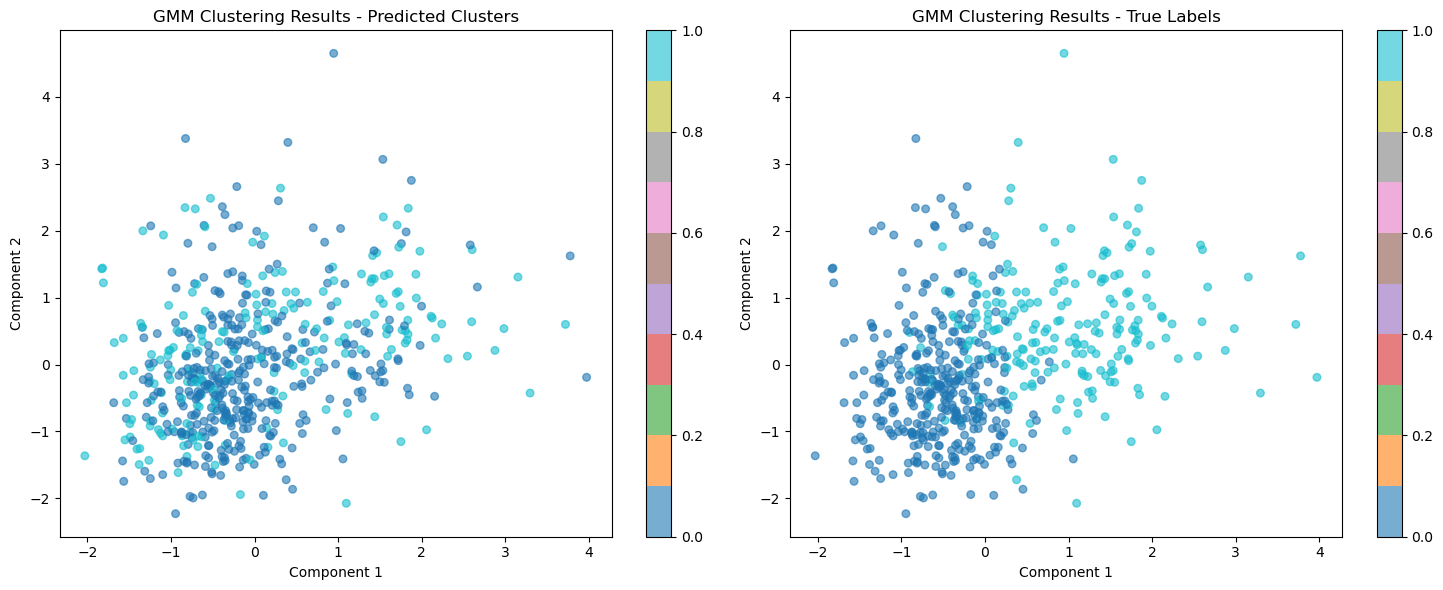

In [ ]:
X_2d = X[:, :2]  # Using first two features for 2D projection
plot_2d_projection(X_2d, pred_labels_gmm, true_labels=y, 
                   centers=None, title='GMM Clustering Results')

# Experiment 3: K-Means after PCA
Run K-Means on PCA-reduced breast cancer data (components: 2, 5, 10, 15, 20) to study reconstruction error vs clustering quality. Metrics: silhouette, Davies-Bouldin, Calinski-Harabasz, WCSS, ARI, NMI, purity; plus confusion matrix for best silhouette and 2D projection.

In [ ]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from Kmeans import KMeans
from PCA import PCA
import part3

sns.set(style="whitegrid")

In [ ]:
# Load and standardize dataset
X_raw, y_true = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X_raw)
print(f"Data shape: {X.shape}, positive class ratio: {y_true.mean():.3f}")

Data shape: (569, 30), positive class ratio: 0.627


In [ ]:
# Run PCA -> KMeans across component counts

def run_pca_kmeans(
    X,
    y_true,
    n_components_list,
    k=2,
    init="kmeans++",
    max_iter=300,
    tol=1e-4,
):
    results = {
        "n_components": [],
        "reconstruction_error": [],
        "explained_variance": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
        "wcss": [],
        "ari": [],
        "nmi": [],
        "purity": [],
        "labels": [],
    }

    for n_comp in n_components_list:
        pca = PCA(n_components=n_comp)
        pca.fit(X)
        X_pca = pca.transform(X)

        rec_err = pca.reconstruction_error(X)
        explained = np.sum(pca.explained_variance_ratio_[:n_comp])

        km = KMeans(k=k, init=init, max_iter=max_iter, tol=tol)
        km.fit(X_pca)
        labels = km.labels_

        sil, _ = part3.silhouette_score(X_pca, labels) if k > 1 else (np.nan, None)
        dbi = part3.davies_bouldin_index(X_pca, labels) if k > 1 else np.nan
        chi = part3.calinski_harabasz_index(X_pca, labels) if k > 1 else np.nan
        wcss = part3.within_cluster_sum_of_squares(X_pca, labels)

        ari = part3.adjusted_rand_index(y_true, labels)
        nmi = part3.normalized_mutual_information(y_true, labels)
        purity = part3.purity_score(y_true, labels)

        results["n_components"].append(n_comp)
        results["reconstruction_error"].append(rec_err)
        results["explained_variance"].append(explained)
        results["silhouette"].append(sil)
        results["davies_bouldin"].append(dbi)
        results["calinski_harabasz"].append(chi)
        results["wcss"].append(wcss)
        results["ari"].append(ari)
        results["nmi"].append(nmi)
        results["purity"].append(purity)
        results["labels"].append(labels)

    return results

In [ ]:
# Plot helpers

def plot_reconstruction_and_variance(n_components, rec_errors, explained):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(n_components, rec_errors, marker="o", color="red")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Reconstruction Error vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(n_components, explained, marker="o", color="blue")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Explained Variance (cumulative)")
    plt.title("Explained Variance vs PCA Components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_clustering_metrics(n_components, results):
    plt.figure(figsize=(14, 12))

    plt.subplot(3, 2, 1)
    plt.plot(n_components, results["silhouette"], marker="o")
    plt.xlabel("PCA Components")
    plt.ylabel("Silhouette")
    plt.title("Silhouette vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 2)
    plt.plot(n_components, results["davies_bouldin"], marker="o", color="orange")
    plt.xlabel("PCA Components")
    plt.ylabel("Davies-Bouldin (lower better)")
    plt.title("Davies-Bouldin vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 3)
    plt.plot(n_components, results["calinski_harabasz"], marker="o", color="green")
    plt.xlabel("PCA Components")
    plt.ylabel("Calinski-Harabasz (higher better)")
    plt.title("Calinski-Harabasz vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 4)
    plt.plot(n_components, results["wcss"], marker="o", color="red")
    plt.xlabel("PCA Components")
    plt.ylabel("WCSS")
    plt.title("WCSS vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 5)
    plt.plot(n_components, results["ari"], marker="o", color="blue")
    plt.xlabel("PCA Components")
    plt.ylabel("Adjusted Rand Index")
    plt.title("ARI vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 6)
    plt.plot(n_components, results["purity"], marker="o", color="brown")
    plt.xlabel("PCA Components")
    plt.ylabel("Purity")
    plt.title("Purity vs PCA components")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion(cm, true_classes, pred_clusters, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {c}" for c in pred_clusters],
        yticklabels=[f"True {c}" for c in true_classes],
    )
    plt.title(title)
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Classes")
    plt.tight_layout()
    plt.show()


def plot_2d_projection(X_2d, labels, true_labels=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette="tab10", s=40, alpha=0.7)
    plt.title("K-Means on 2D PCA projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if true_labels is not None:
        plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [ ]:
# Run experiment and pick best silhouette configuration
n_components_list = [2, 5, 10, 15, 20]

results = run_pca_kmeans(X, y_true, n_components_list, k=2, init="kmeans++")

best_idx = int(np.nanargmax(results["silhouette"]))
best_n = results["n_components"][best_idx]
best_labels = results["labels"][best_idx]
cm, true_classes, pred_clusters = part3.confusion_matrix(y_true, best_labels)

print(f"Best silhouette at n_components={best_n}: score={results['silhouette'][best_idx]:.3f}")
print(
    f"Reconstruction error={results['reconstruction_error'][best_idx]:.4f}, "
    f"Explained variance={results['explained_variance'][best_idx]:.3f}"
)

print("\nSummary metrics (per n_components):")
for idx, n_comp in enumerate(results["n_components"]):
    print(
        f"n={n_comp:>2} | rec_err={results['reconstruction_error'][idx]:.4f} "
        f"expl_var={results['explained_variance'][idx]:.3f} sil={results['silhouette'][idx]:.3f} "
        f"dbi={results['davies_bouldin'][idx]:.3f} chi={results['calinski_harabasz'][idx]:.2f} "
        f"wcss={results['wcss'][idx]:.2f} ari={results['ari'][idx]:.3f} "
        f"nmi={results['nmi'][idx]:.3f} purity={results['purity'][idx]:.3f}"
    )

Best silhouette at n_components=2: score=0.508
Reconstruction error=0.3676, Explained variance=0.632

Summary metrics (per n_components):
n= 2 | rec_err=0.3676 expl_var=0.632 sil=0.508 dbi=0.844 chi=580.78 wcss=5332.98 ari=0.665 nmi=0.547 purity=0.909
n= 5 | rec_err=0.1527 expl_var=0.847 sil=0.393 dbi=1.141 chi=345.07 wcss=8991.83 ari=0.671 nmi=0.555 purity=0.910
n=10 | rec_err=0.0484 expl_var=0.952 sil=0.358 dbi=1.257 chi=288.09 wcss=10770.71 ari=0.677 nmi=0.562 purity=0.912
n=15 | rec_err=0.0135 expl_var=0.986 sil=0.347 dbi=1.306 chi=273.08 wcss=11365.42 ari=0.654 nmi=0.532 purity=0.905
n=20 | rec_err=0.0044 expl_var=0.996 sil=0.344 dbi=1.316 chi=269.43 wcss=11520.17 ari=0.659 nmi=0.538 purity=0.907


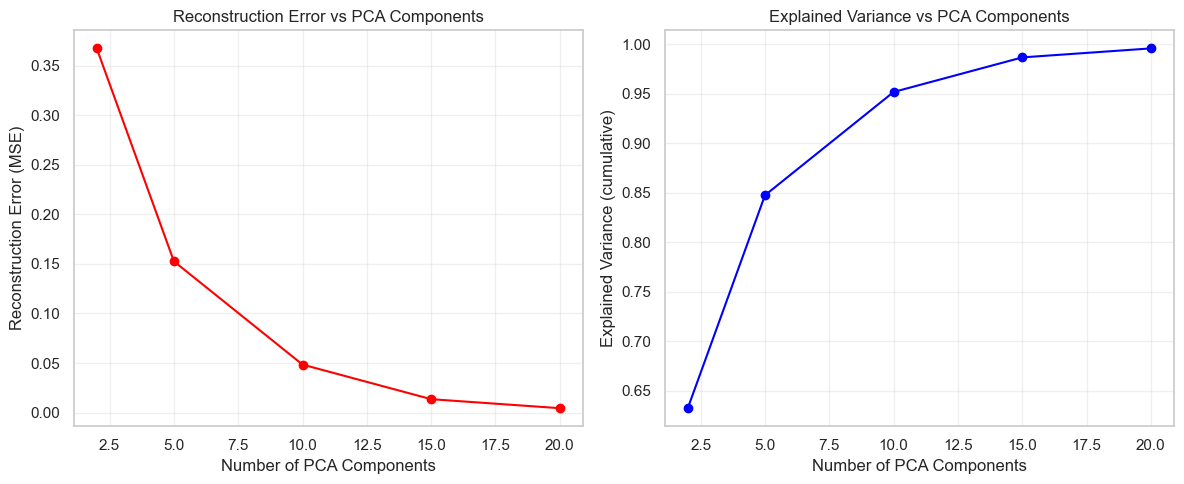

In [ ]:
# Plots: reconstruction error and explained variance
plot_reconstruction_and_variance(
    results["n_components"],
    results["reconstruction_error"],
    results["explained_variance"],
)

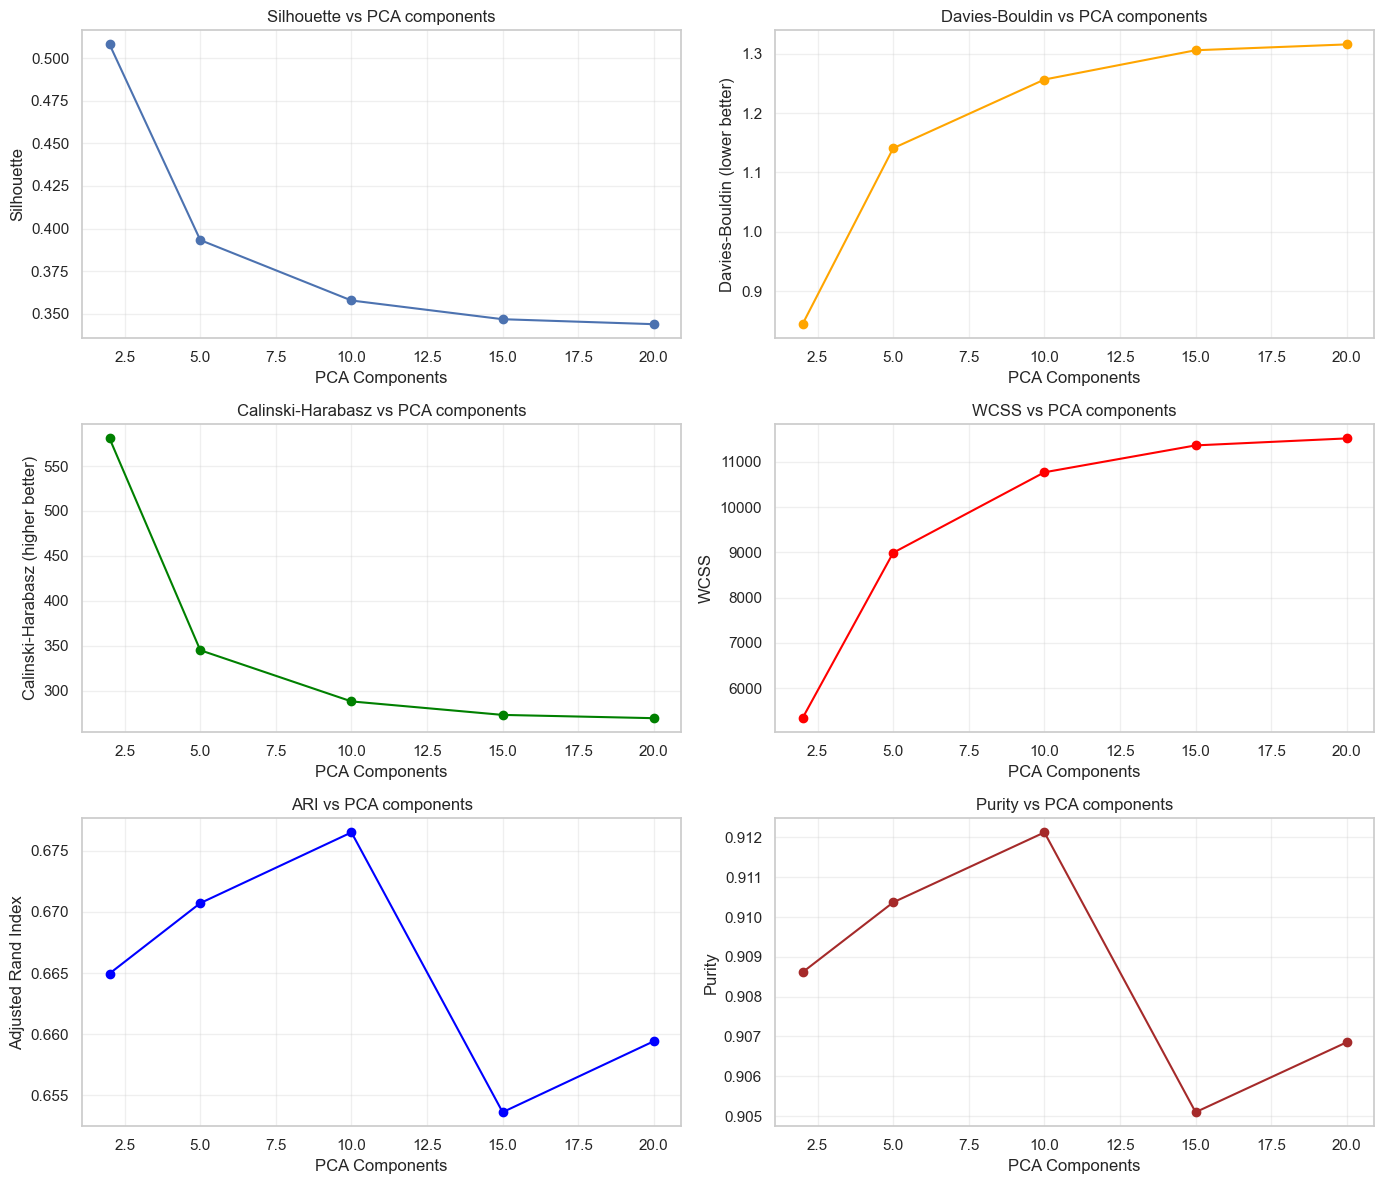

In [ ]:
# Plots: clustering metrics across PCA dimensions
plot_clustering_metrics(results["n_components"], results)

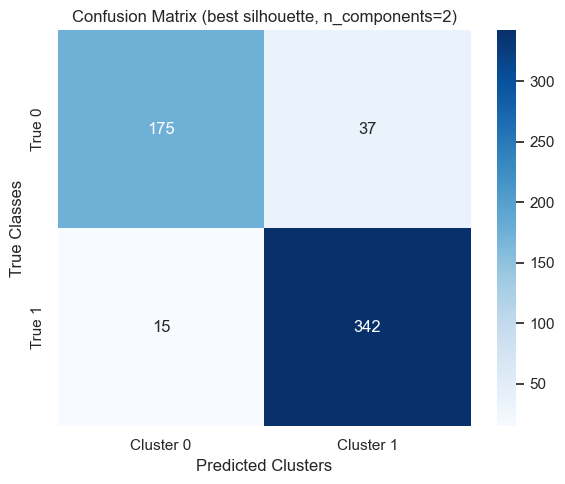

In [ ]:
# Confusion matrix for best silhouette setup
title = f"Confusion Matrix (best silhouette, n_components={best_n})"
plot_confusion(cm, true_classes, pred_clusters, title)

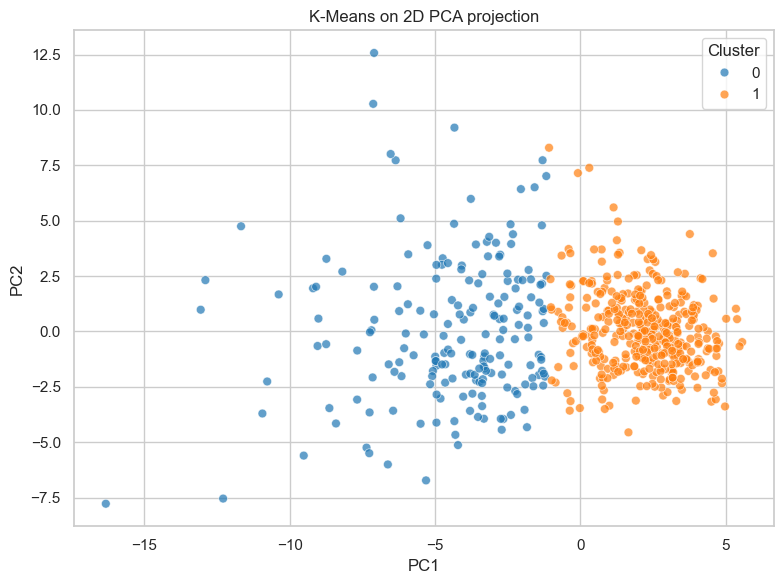

In [ ]:
# 2D visualization when n_components includes 2
if 2 in n_components_list:
    pca2 = PCA(n_components=2)
    pca2.fit(X)
    X2 = pca2.transform(X)
    km2 = KMeans(k=2, init="kmeans++", max_iter=300, tol=1e-4)
    km2.fit(X2)
    plot_2d_projection(X2, km2.labels_, y_true)
else:
    print("n_components=2 not in list; skipping 2D projection.")